
# PyTorch Version of the TensorFlow Notebook

This notebook replicates the exact functionality of the original TensorFlow-based notebook using PyTorch. It includes:
- Data loading and preprocessing (from images and CSV files)
- Building and training a CNN model for classification
- Model evaluation and predictions
- Saving model weights


In [53]:

import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns


In [54]:
print(torch.cuda.is_available())

True


In [55]:
img_size = (160, 120)
img_x = img_size[0]
img_y = img_size[1]

save_model = True

In [56]:

# Function to load and preprocess images and labels
def load_data(image_folder, label_file, target_size=img_size):
    labels_df = pd.read_csv(label_file)
    images = []
    labels = []

    # Create a dictionary to map letters to numerical labels
    unique_letters = labels_df['label'].unique()  # Get unique letters from the 'label' column
    letter_to_label_dict = {letter: i for i, letter in enumerate(unique_letters)}

    for index, row in labels_df.iterrows():
        img_path = os.path.join(image_folder, row['image'])  # Use 'image' column
        img = Image.open(img_path).convert("L")
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0
        images.append(img_array)

        # Convert letter label to numerical label using the dictionary
        labels.append(letter_to_label_dict[row['label']])

    return np.array(images), np.array(labels), letter_to_label_dict  # Return the dictionary

# Load the dataset
image_folder = "./"
label_file = "./labels.csv"  # Updated label file name
X, y, letter_to_label_dict = load_data(image_folder, label_file)  # Get the dictionary from the function call

# Create the label to letter dictionary
label_to_letter_dict = {i: letter for letter, i in letter_to_label_dict.items()}


In [57]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [58]:

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = ImageDataset(X_train, y_train)
test_dataset = ImageDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [59]:
from model import CNNModel

# Instantiate the model
input_shape = (1, img_x, img_y)  # Grayscale image: 1 channel, 60x80 dimensions
model = CNNModel(num_classes=len(np.unique(y)))
model.initialize_fc_layers(input_shape)

Initialized fc1 with input size 7680 and output size 512
Initialized fc2 with input size 512 and output size 256
Initialized fc3 with input size 256 and output size 62


In [60]:
# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 75  # Match TensorFlow's training epochs
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/75, Loss: 4.1615
Epoch 2/75, Loss: 4.0130
Epoch 3/75, Loss: 3.5821
Epoch 4/75, Loss: 2.8988
Epoch 5/75, Loss: 2.3525
Epoch 6/75, Loss: 1.9687
Epoch 7/75, Loss: 1.7209
Epoch 8/75, Loss: 1.5833
Epoch 9/75, Loss: 1.3403
Epoch 10/75, Loss: 1.1902
Epoch 11/75, Loss: 1.0787
Epoch 12/75, Loss: 1.1087
Epoch 13/75, Loss: 1.0519
Epoch 14/75, Loss: 1.0259
Epoch 15/75, Loss: 0.9824
Epoch 16/75, Loss: 0.8658
Epoch 17/75, Loss: 0.7070
Epoch 18/75, Loss: 0.6943
Epoch 19/75, Loss: 0.7719
Epoch 20/75, Loss: 0.7981
Epoch 21/75, Loss: 0.6762
Epoch 22/75, Loss: 0.7840
Epoch 23/75, Loss: 0.7449
Epoch 24/75, Loss: 0.7347
Epoch 25/75, Loss: 0.6674
Epoch 26/75, Loss: 0.6932
Epoch 27/75, Loss: 0.6160
Epoch 28/75, Loss: 0.6294
Epoch 29/75, Loss: 0.5242
Epoch 30/75, Loss: 0.5935
Epoch 31/75, Loss: 0.6673
Epoch 32/75, Loss: 0.5193
Epoch 33/75, Loss: 0.5649
Epoch 34/75, Loss: 0.5354
Epoch 35/75, Loss: 0.5008
Epoch 36/75, Loss: 0.4290
Epoch 37/75, Loss: 0.5025
Epoch 38/75, Loss: 0.3862
Epoch 39/75, Loss: 0.

In [61]:

# Evaluate the model
model.eval()
all_preds = []
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to the same device as the model
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.74


In [62]:
import pickle


# Save the model weights
if save_model:
    torch.save(model.state_dict(), './weights/cnn_weights.pth')

    # Save the label_to_letter_dict for later use
    with open('./weights/label_to_letter_dict.pkl', 'wb') as f:
        pickle.dump(label_to_letter_dict, f)

In [63]:
from sklearn.metrics import confusion_matrix

# Generate predictions and compute the confusion matrix
y_true = []  # Collect true labels
y_pred = []  # Collect predicted labels

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to the same device as the model
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())  # Move to CPU before converting to numpy
        y_pred.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy

# Convert numerical labels back to letters
y_true_letters = [label_to_letter_dict[label] for label in y_true]
y_pred_letters = [label_to_letter_dict[label] for label in y_pred]

# Unique letters (characters)
unique_letters = list(label_to_letter_dict.values())

# Compute confusion matrix
cm = confusion_matrix(y_true_letters, y_pred_letters, labels=unique_letters)

# Calculate accuracy per character
accuracy_per_char = np.diag(cm) / np.sum(cm, axis=1)
char_accuracy_dict = dict(zip(unique_letters, accuracy_per_char))

# Sort characters by accuracy in descending order
sorted_char_accuracy = sorted(char_accuracy_dict.items(), key=lambda item: item[1], reverse=True)

# Get the best and worst 3 characters
best_3_chars = sorted_char_accuracy[:3]
worst_3_chars = sorted_char_accuracy[-3:]

# Print the results
print("Best 3 Characters:")
for char, accuracy in best_3_chars:
    print(f"{char}: {accuracy:.2f}")

print("\nWorst 3 Characters:")
for char, accuracy in worst_3_chars:
    print(f"{char}: {accuracy:.2f}")


Best 3 Characters:
D: 1.00
5: 0.95
A: 0.95

Worst 3 Characters:
q: 0.47
r: 0.47
o: 0.42


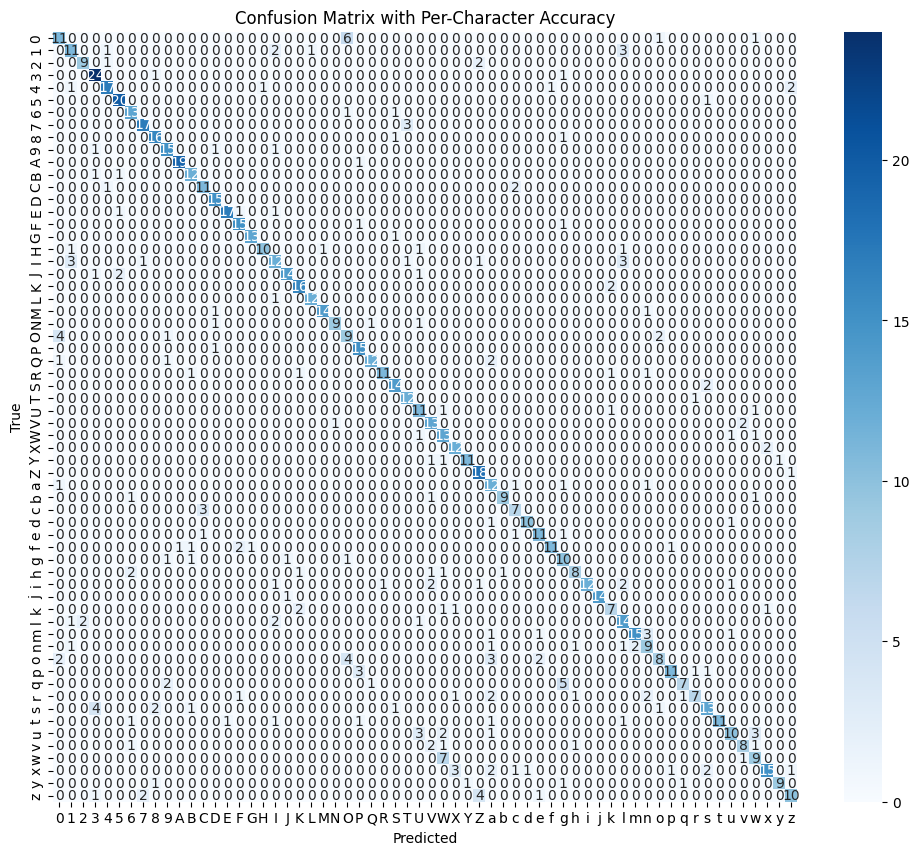

In [64]:
# Heatmap
# Plot heatmap for confusion matrix
plt.figure(figsize=(12, 10))  # Adjust the size if needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_letters, yticklabels=unique_letters)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Per-Character Accuracy')
plt.show()


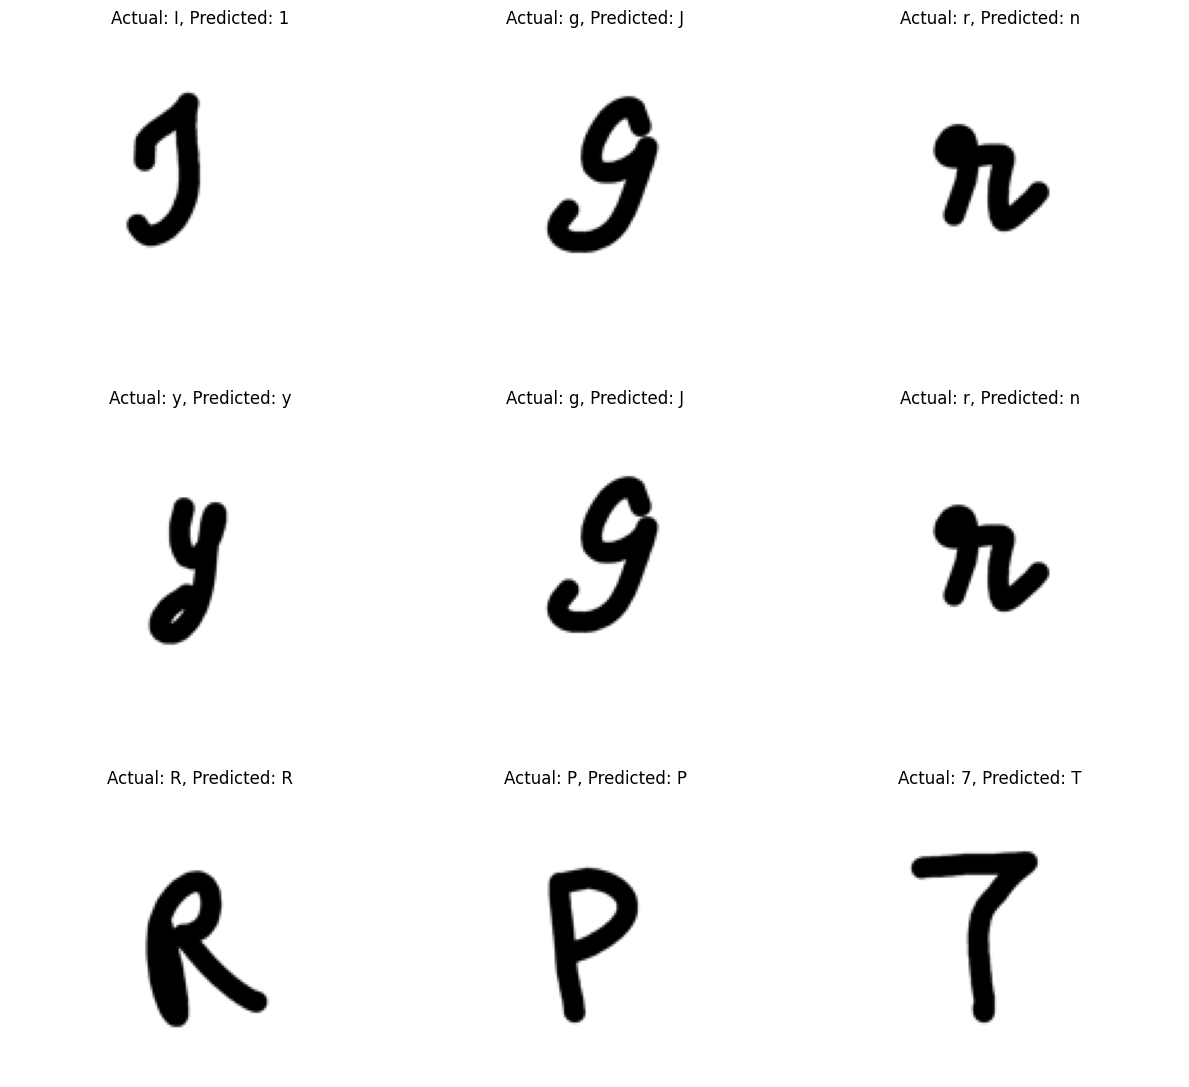

In [65]:
# Images and Predictions
# Visualize some test images with their predictions
import random

# Get a batch of test data
data_iter = iter(test_loader)
X_batch, y_batch = next(data_iter)

# Run the model on the batch
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to the same device as the model
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())  # Move to CPU before converting to numpy
        y_pred.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy

# Display a few images with their predicted and actual labels
plt.figure(figsize=(12, 12))
for i in range(9):  # Display 9 images
    idx = random.randint(0, len(X_batch) - 1)  # Pick a random index from the batch
    image = X_batch[idx].cpu().squeeze().numpy()  # Move to CPU, get the image and remove channel dimension
    actual_label = label_to_letter_dict[y_batch[idx].cpu().item()]
    predicted_label = label_to_letter_dict[preds[idx].cpu().item()]

    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()
